# Visualization and data analysis of output indicators 

This notebook presents data visualization and analysis for output indicators from the Global indicator project.   
The analyses consist of two major components:  
   1. Within-city variations
    - Show maps of walkability indicators for all cities and do a visual sanity check to see if any issue occurs
    - Interpret the within-city variation patterns
    - Pick one or two cities as examples, plot different indicators and compare, interprete the within-city variations and how that may or may not represent the real-world situation

   2. Between-city analysis
    - Show tables for measurements and raw indicator number, rank cities from the highest to the lowest, and interprete the results
    - Plot in a world map using graduated symbol or color to visualize and compare indicators across cities
    - Create box plot to compare median statistics across cities
    - We could may be do similar analyses like policy indicators analyses to color code cities based on the lancet study threshold?
    

**Note: Refer to the [workflow documentation](https://github.com/gboeing/global-indicators/blob/master/documentation/workflow.md) for indicators tables and description**
    
    

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import os
import time
from multiprocessing import Pool, cpu_count, Value, Manager, Process
from functools import partial
import json
import sys
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# get the work directory
dirname = os.path.abspath('')

# the configuration file should put in the "/configuration" folder located at the same folder as scripts
jsonFile = 'configuration/' + sys.argv[1]

In [4]:
# read json file
try:
    jsonPath = os.path.join(dirname, jsonFile)
    with open('configuration/cities.json') as json_file:
        config = json.load(json_file)
except Exception as e:
    print('Failed to read json file.')
    print(e)

folder = config['folder']
input_folder = config['input_folder']

# read city names from json
cities = list(config["gpkgNames"].keys())
print("Cities:{}".format(cities))

# the path of "global_indicators_hex_250m.gpkg"
gpkgOutput_hex250 = os.path.join(dirname, folder,
                                 config['output_hex_250m'])

# create the path of "global_indicators_city.gpkg"
gpkgOutput_cities = os.path.join(dirname, folder,
                                 config['global_indicators_city'])

Cities:['adelaide', 'auckland', 'baltimore', 'bangkok', 'barcelona', 'belfast', 'bern', 'chennai', 'cologne', 'ghent', 'graz', 'hanoi', 'hong_kong', 'lisbon', 'melbourne', 'mexico_city', 'odense', 'olomouc', 'phoenix', 'sao_paulo', 'seattle', 'sydney', 'valencia', 'vic']


## 1. Within-city variations

### All cities

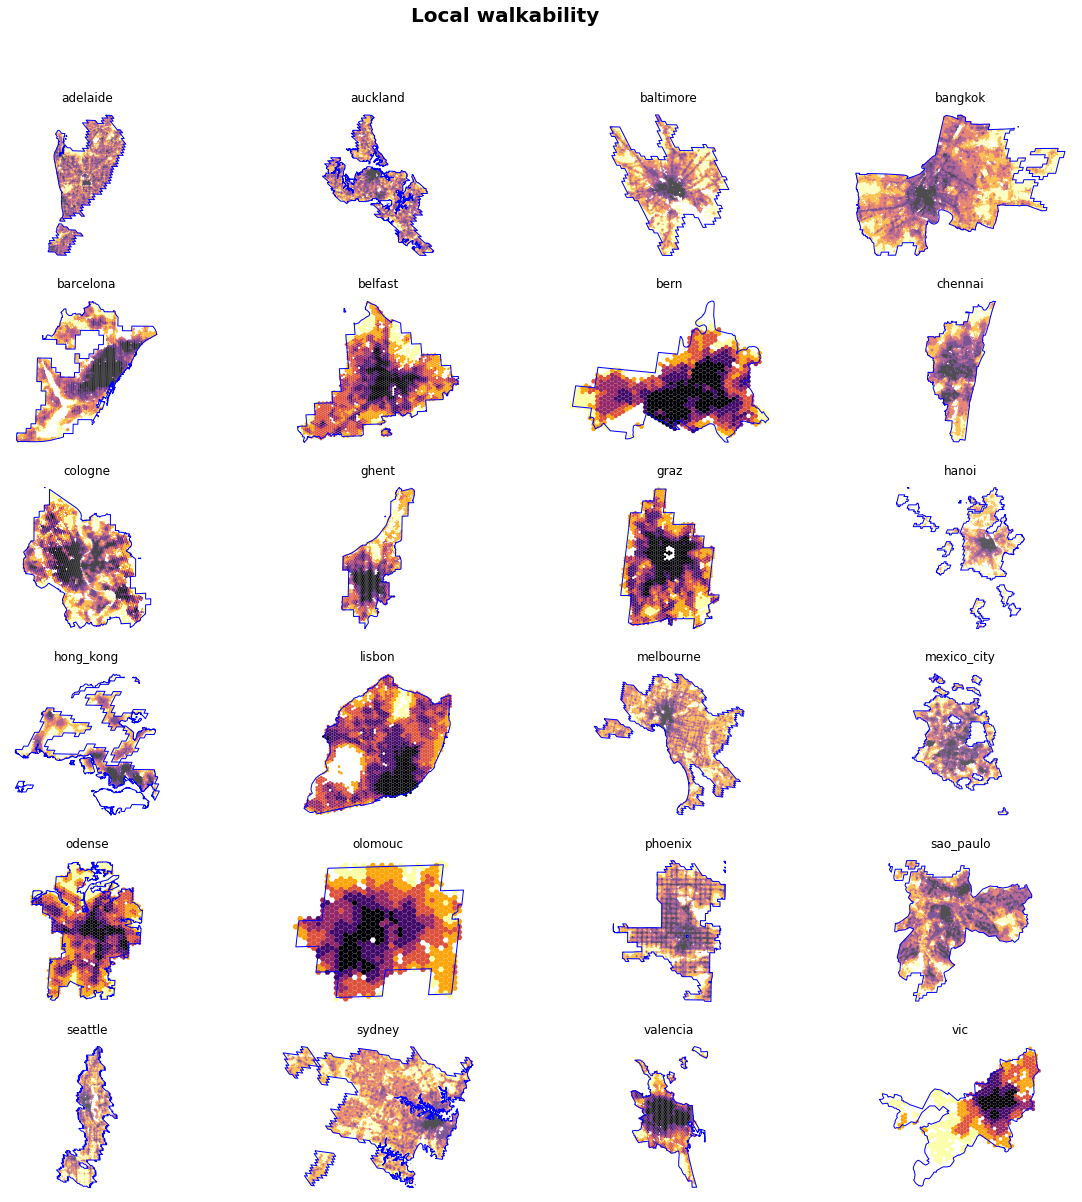

In [13]:
col='all_cities_walkability'

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))

for ax, city in zip(axes.flatten(), cities):
    #read file
    hex250 = gpd.read_file(gpkgOutput_hex250, layer=city)
    city_bound = gpd.read_file(gpkgOutput_cities, layer=city)
    
    #plot indicators
    ax = hex250.plot(ax=ax, column=col, scheme='NaturalBreaks', k=6, cmap='inferno_r', edgecolor='none')
    ax = city_bound.plot(ax=ax, color='none', edgecolor='blue')

    ax.set_title(city, fontsize=12)
    ax.set_axis_off()

# add a title to the figure
fig.suptitle('Local walkability', y=0.95, fontsize=20, weight='bold')

fig.savefig('maps/walkability.png', dpi=600)

plt.show()

### Plot one city as an example - Phoenix

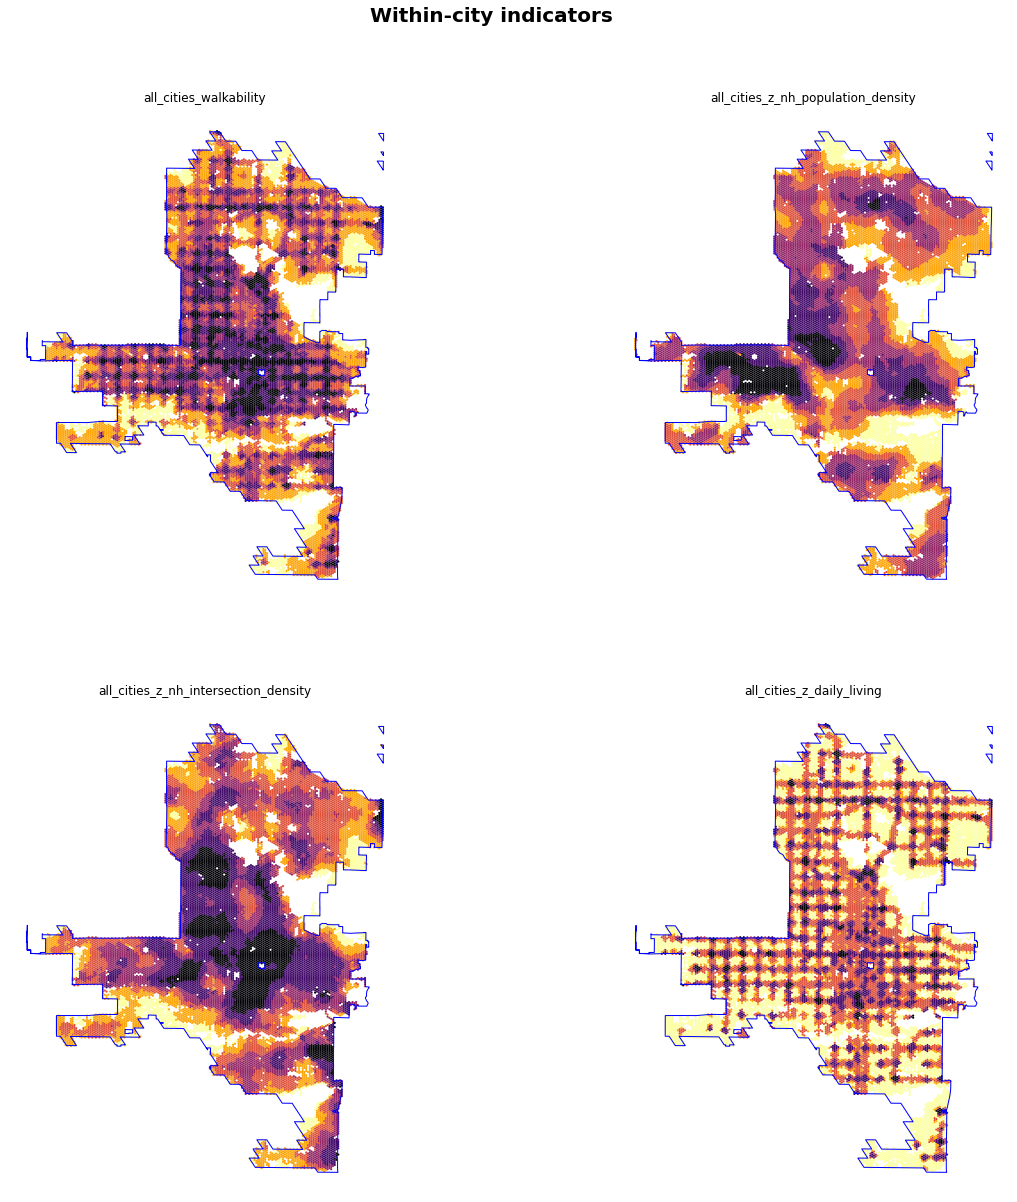

In [17]:
cols=['all_cities_walkability', 'all_cities_z_nh_population_density', 'all_cities_z_nh_intersection_density', 'all_cities_z_daily_living']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

for ax, col in zip(axes.flatten(), cols):
    #read file
    hex250 = gpd.read_file(gpkgOutput_hex250, layer='phoenix')
    city_bound = gpd.read_file(gpkgOutput_cities, layer='phoenix')
    
    #plot indicators
    ax = hex250.plot(ax=ax, column=col, scheme='NaturalBreaks', k=6, cmap='inferno_r', edgecolor='none')
    ax = city_bound.plot(ax=ax, color='none', edgecolor='blue')

    ax.set_title(col, fontsize=12)
    ax.set_axis_off()

# add a title to the figure
fig.suptitle('Within-city indicators', y=0.95, fontsize=20, weight='bold')

fig.savefig('maps/within-city_phoenix.png', dpi=600)

plt.show()

## 2. Between-city variations

In [6]:
cities_ind = gpd.GeoDataFrame()
for city in cities:
    #read file
    city_ind = gpd.read_file(gpkgOutput_cities, layer=city)
    cities_ind = cities_ind.append(city_ind, ignore_index=True)

In [7]:
#correct vic study region column
cities_ind['Study region'] = cities_ind['Study region'].fillna('Vic')
cities_ind.columns

Index(['Study region', 'urban_sample_point_count',
       'pop_pct_access_500m_supermarkets', 'pop_pct_access_500m_convenience',
       'pop_pct_access_500m_pt_any', 'pop_pct_access_500m_public_open_space',
       'pop_nh_pop_density', 'pop_nh_intersection_density', 'pop_daily_living',
       'pop_walkability', 'all_cities_pop_z_daily_living',
       'all_cities_walkability', 'geometry', 'db', 'area_sqkm'],
      dtype='object')

In [8]:
cities_ind[['Study region', 'all_cities_pop_z_daily_living', 'all_cities_walkability',
       'pop_daily_living', 'pop_nh_intersection_density', 'pop_nh_pop_density',
       'pop_pct_access_500m_convenience', 'pop_pct_access_500m_pt_any',
       'pop_pct_access_500m_public_open_space',
       'pop_pct_access_500m_supermarkets', 'pop_walkability', 'all_cities_pop_z_daily_living',
       'all_cities_walkability', 'urban_sample_point_count']].to_csv('maps/all_globe_cities_ind.csv')

In [9]:
# show pop-weighted walkability score ranking relative to all cities
cities_ind[['Study region', 'all_cities_walkability']].sort_values('all_cities_walkability').reset_index().drop(columns=['index'])

,Study region,all_cities_walkability
0,Adelaide,-0.760635
1,Melbourne,-0.329960
2,Sydney,-0.287855
3,Seattle,-0.205080
4,Phoenix,-0.185019
5,Ghent,0.137171
6,Auckland,0.148206
7,Vic,0.312587
8,Baltimore,0.560196
9,Bangkok,0.819583
